# Classical Time-Series Modelling Methods

Exploring machine learning time-series methods using StatsModels library and US unemployment data generated by BLS https://data.bls.gov/timeseries/LNS14000000

There is only one official definition of unemployment—people who are jobless, actively seeking work, and available to take a job. The official unemployment rate for the nation is the number of unemployed as a percentage of the labor force (the sum of the employed and unemployed). 

In [14]:
from blsconnect import RequestBLS, bls_search
import pandas as pd

bls = RequestBLS()

series_names = bls_search(data="U3")
bls_api = bls.series(series_names,
                start_year=2010,
                end_year=2020)

In [18]:
bls_api.head()

,year,period,periodName,LNS14000000
0,2010,M01,January,9.8
1,2010,M02,February,9.8
2,2010,M03,March,9.9
3,2010,M04,April,9.9
4,2010,M05,May,9.6


In [19]:
bls_api.rename(mapper={'periodName':'Month', 'LNS14000000':'US Unemployment Rate %'}, axis=1, inplace=True)
bls_api['Date'] = bls_api['year'].map(str) + " " + bls_api['Month']
bls_api['Date'] = pd.to_datetime(bls_api.Date, yearfirst=True)
bls_api.drop(columns=['period','year','Month'], inplace=True)

In [20]:
bls_api.head()

,US Unemployment Rate %,Date
0,9.8,2010-01-01
1,9.8,2010-02-01
2,9.9,2010-03-01
3,9.9,2010-04-01
4,9.6,2010-05-01


In [24]:
bls_api.Date.min()

Timestamp('2010-01-01 00:00:00')

### "Rolling Functions" 

With a time-series we can roll or move statistics across time. For example, the rolling mean is the mean of a set period across time. 

A moving average is commonly used with time series data to smooth out short-term fluctuations and highlight longer-term trends or cycles.

### Autocorrelation

Autocorrelation in statistics is a mathematical tool that is usually used for analyzing functions or series of values, for example, time domain signals. In other words, autocorrelation determines the presence of correlation between the values of variables that are based on associated aspects. In a way, it is the cross-correlation of a signal with itself. Most of the statistical models are based upon the assumption of instance independence, which gets desecrated by autocorrelation.

In [4]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

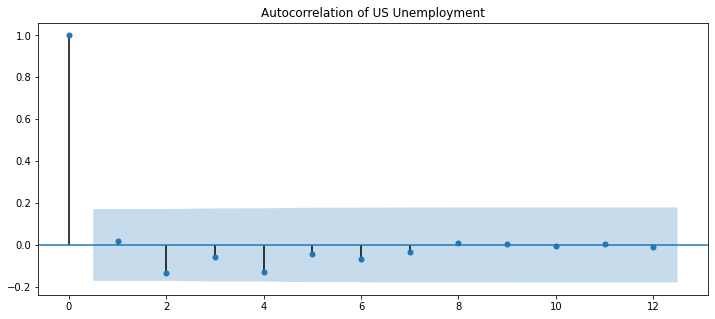

In [5]:
#Unemployment Difference calculates the difference between the current and 1 preceding value
bls_api_diff = bls_api['US Unemployment Rate %'].diff()
bls_api_diff.dropna(inplace=True)

# Using statsmodels acf function we can see there is minimal autocorrelation
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(bls_api_diff.values, lags=12, ax=ax, title='Autocorrelation of US Unemployment')
plt.show()

### Autoregression 

An Autoregression model predicts the next step in a time-series set of data, based on previous steps. It is a linear model that outputs a value based on  linear combination of values.

**This method is most suitable for univariate time-series analysis without seasonal trends or components.**

In [6]:
from statsmodels.tsa.ar_model import AutoReg
import plotly
import plotly.express as px
import plotly.graph_objects as go
import json

In [45]:
#fitting model
AR = AutoReg(bls_api['US Unemployment Rate %'], lags=2)
AR_fit = AR.fit()

#predictions
yhat = AR_fit.predict()

#Plotting AR with original data
def time_plot(model_name, yhat):
    AR_join = pd.DataFrame.join(bls_api, yhat.to_frame(name='y-hat'))

    AR_join.to_json()

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=AR_join.Date, y=AR_join['US Unemployment Rate %'], name='Raw-Data',
                             line=dict(color='navy')))

    fig.add_trace(go.Scatter(x=AR_join.Date, y=AR_join['y-hat'], name='Predicted Data',
                             line=dict(color='orange')))

    fig.update_xaxes(rangeslider_visible=True,
                     showspikes=True,
                     spikethickness=1,
                     rangeselector=dict(
                     buttons=list([
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(step="all")
                     ])
                     )
                    )

    fig.update_yaxes(showspikes=True,
                     spikethickness=1)

    fig.update_layout(title="US Unemployment with " + model_name ,
                      xaxis_title='Month',
                      yaxis_title='Unemployment %')

    fig.show()

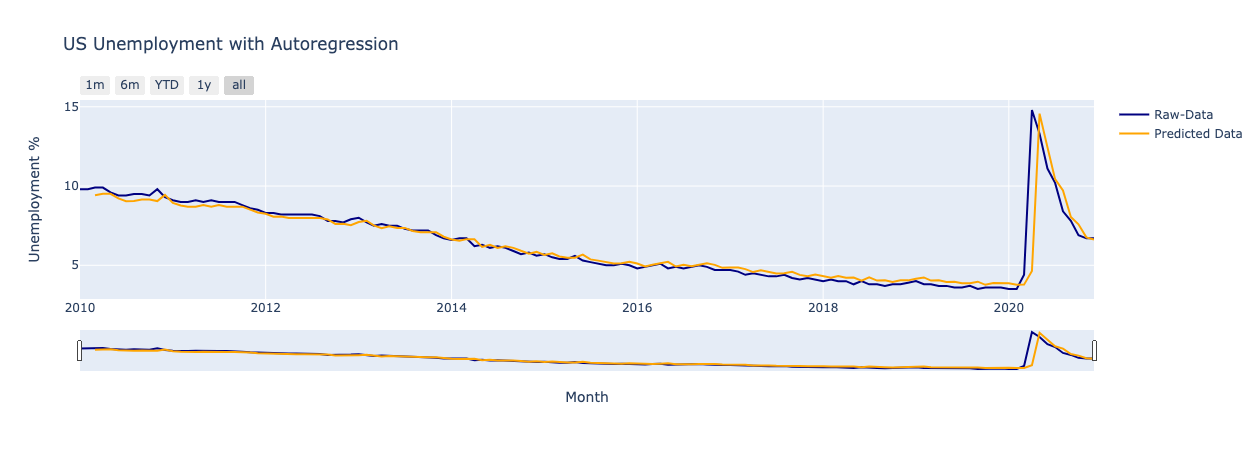

In [47]:
time_plot('Autoregression', yhat)

### Moving Average (MA)

The moving average can be used to make predictions for the next step in a time-series, as a linear-function of the residual errors. 

It is a naive model (based exclusively on historical data, and do not consider any underlying relationships) that assumes seasonal and trend components of the data have been removed or adjusted for.

As new observations are made, models can be updated to unclude those and predict the next time-period. 

We can use ARIMA to create a MA model 

**This method is most suitable for univariate time-series analysis without seasonal trends or components.**

In [29]:
from statsmodels.tsa.arima.model import ARIMA
# Loading & Fitting the model - Non-seasonal ARIMA models are denoted with (p,d,q) where p denotes the number of time lags, d is the differencing or the number of times data has been subtracted, and q is the order of the moving-average model. In this case we are using the order or 1.
ma = ARIMA(bls_api['US Unemployment Rate %'], order=(0,0,1))
ma_fit = ma.fit()

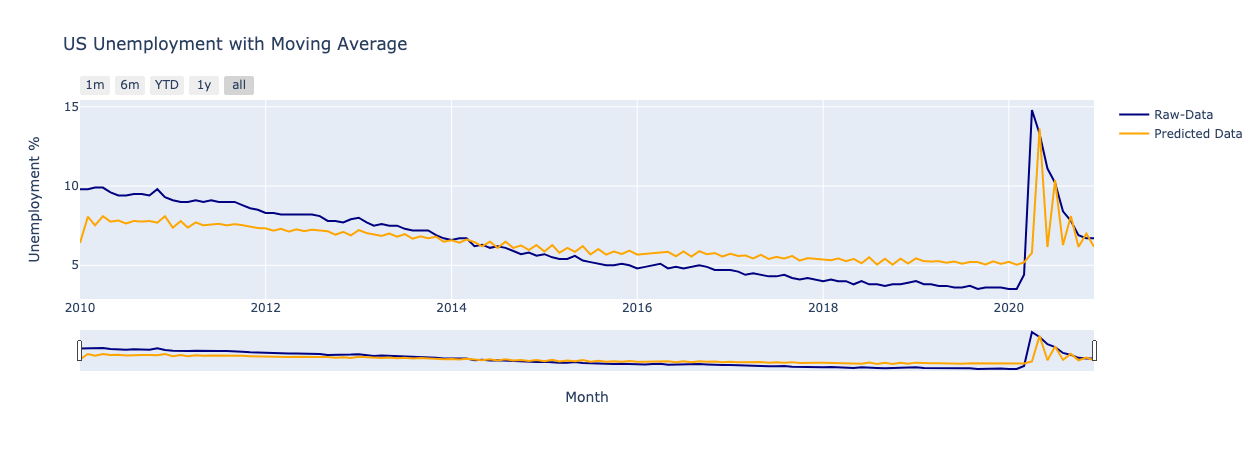

In [48]:
# Predicting using MA and plotting against the original raw data
yhat_ma = ma_fit.predict()
time_plot('Moving Average', yhat_ma)

### Auto-Regressive Moving Average (ARMA)

ARMA is a combination of the 'Auto-Regression' & 'Moving Average' models. So models the next step in the sequence as a linear function of the observations and residual errors from the previous steps. 

**It is suitable for univariate analysis without seasonal or trend components**

/Users/Nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/Nick/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



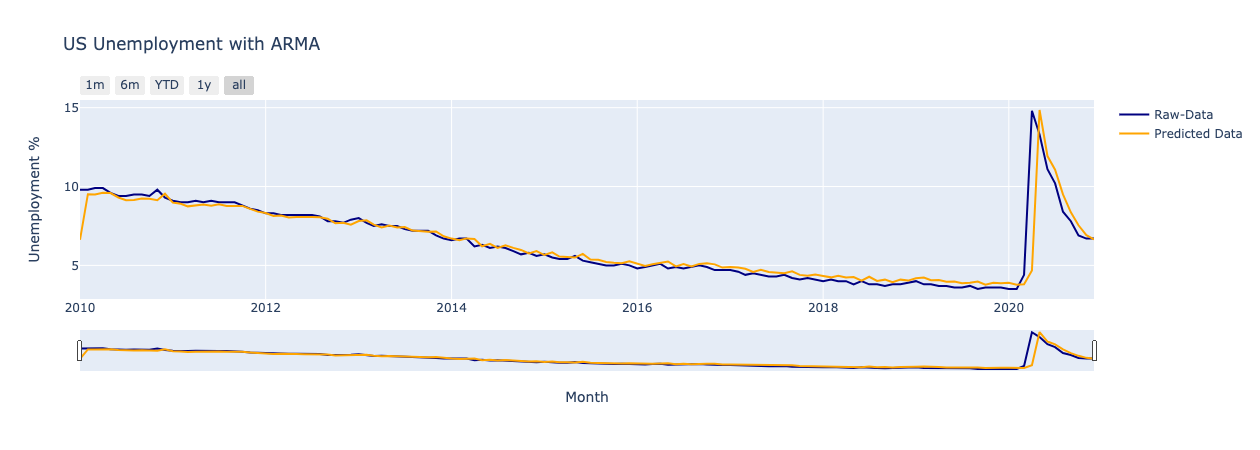

In [49]:
# Loading the ARMA model using a time-lag of 2, differencing of 0, and a order of moving average to be 1. 
arma = ARIMA(bls_api['US Unemployment Rate %'], order=(2,0,1))
# Fitting the model 
arma_fit = arma.fit()
# Predictions using the model
yhat_arma = arma_fit.predict()
# Plotting the model
time_plot('ARMA',yhat_arma)

### Auto-Regressive Integrated Moving Average (ARIMA)

The ARIMA method combines the ***'Auto-Regression'***, ***'Moving Average'*** models, as well as a differencing pre-processing technique called ***'Integration'*** to make the sequence stationary.

**The model is suitable for sequences WITH trend and WITHOUT seasonal components**

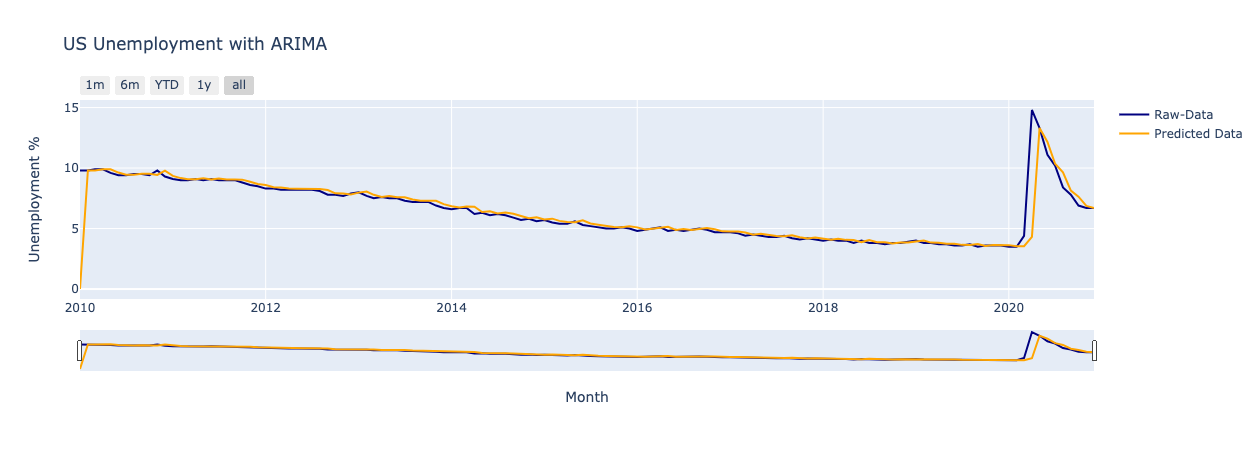

In [50]:
# Initialising the ARIMA model
arima = ARIMA(bls_api['US Unemployment Rate %'], order=(1,1,1))
# Fitting the ARIMA model to the data
arima_fit = arima.fit()
# Predictions using the model
yhat_arima = arima_fit.predict()
# Plotting predicted against the raw data
time_plot('ARIMA', yhat_arima)

### Seasonal Auto-Regressive Integrated Moving Average (SARIMA)

SARIMA models the next value in a sequence as a linear function of the differenced observations, errors, differenced seasonal observations, and seasonal errors. It combines the ARIMA model with the ability to perform the same autoregression, differencing, at a seasonal level.

**The model is suitable for univariate sequences WITH a seasonal and/or trend component.**

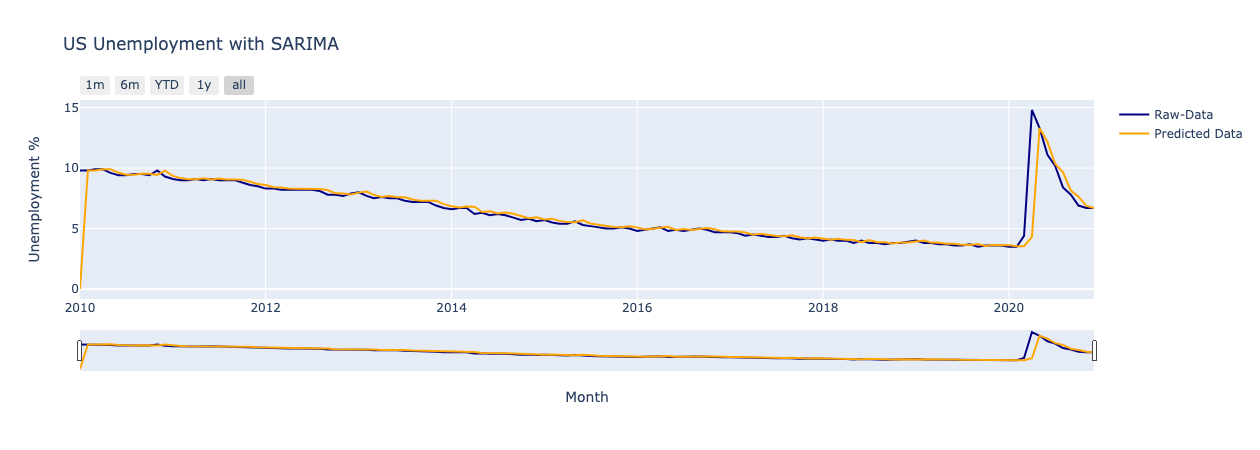

In [52]:
# Loading the model 
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Initiate the model
sarima = SARIMAX(bls_api['US Unemployment Rate %'], order=(1,1,1), seasonal_order=(0,0,0,0))
# Fitting model
sarima_fit = sarima.fit()
# Preditions from the model 
yhat_sarima = sarima_fit.predict()
# Plotting the predictions against the raw data
time_plot('SARIMA',yhat_sarima)